# *Часть 1 - выгрузка текста*

In [ ]:
import requests
from bs4 import BeautifulSoup
import json

In [ ]:
my_text=[]
page=0
i=0
while i<=1000:
  page0=requests.get('http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/{}'.format(page))
  soup=BeautifulSoup(page0.content, 'html.parser')
  t=soup.find('p', class_='appeal-details-message')
  if t != None:
    my_text.append(t.get_text())
    i = i+1
  page=page+1

In [ ]:
with open('my_text.txt', 'w') as f:
   f.write(json.dumps(my_text))

In [ ]:
with open('my_text.txt', 'r') as f:
  my_text = json.loads(f.read())

# *Часть 2 - предобработка текста*

### *Регулярные выражения*

In [ ]:
import re

In [ ]:
complaints=my_text.copy()

In [ ]:
for i in range (len (complaints)):
  complaints[i] = re.sub("[a-zA-Z]+", "", complaints[i]) #удаляем все английские слова
  complaints[i]=re.sub(r'\w*\d\w*', '', complaints[i]).strip() #удаляем числа
  complaints[i]=re.sub(r'[^\w\s]', '', complaints[i]) #удаляем пунктуацию
  complaints[i]=re.sub(r'\n', '', complaints[i]) #удаляем разрыв строки  
  complaints[i]=re.sub(r' +', ' ', complaints[i]) #удаляем лишние пробелы   

### *Preprocessing*

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
from string import punctuation

In [ ]:
!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='ru')

In [ ]:
!pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='ru')

In [ ]:
from autocorrect import Speller

In [ ]:
from gensim import corpora
from gensim import models

In [ ]:
#tokinize
text = [word_tokenize(document) for document in complaints]

In [ ]:
#удалим пробелы 
text = [
     [token.strip().lower() for token in document]
     for document in text]

In [ ]:
#удалим стоп-слова
stopwords = set(stopwords.words('russian'))
stopwords_text = [
     [word for word in document if word not in stopwords]
     for document in text
 ]

In [ ]:
#еще раз дропнем пунктуацию
punctuation += '--'
punctuation += "..."
punctuation +="========================================================================"
punctuation += "''"
punctuation += "``"
punctuation += "wa"
punctuation_text = [
     [word for word in document if word not in punctuation]
     for document in stopwords_text
 ]

In [ ]:
#лемматизация (используем pymorphy2 как более адаптивный к русскому языку)
ru_lemm = [[morph.parse(w)[0].normal_form for w in document]
           for document in punctuation_text]

In [ ]:
#еще раз удаляем стоп слова
lem_text = [
     [word for word in document if word not in stopwords]
     for document in ru_lemm
 ]

In [ ]:
#удалим шаблонные слова и обращения, которые не помогают узнать суть текста, так же удалим мусорные слова
bad_words = ["Здравствуйте", "Добрый", "день", "вечер", "утро", "пожалуйста", "помогите", 'su', 'г', 'тк']
clean_text = [
     [word for word in document if word not in bad_words]
     for document in lem_text
 ]

In [ ]:
#автокоррекция
spell = Speller(lang='ru')
correct_text = [
                [spell(word) for word in document]
                for document in clean_text
]

In [ ]:
#создаем словарь 
dictionary = corpora.Dictionary(correct_text)

In [ ]:
#проводим векторизацию
corpus = [dictionary.doc2bow(text) for text in correct_text]

In [ ]:
#tf-idf model
tfidf_model = models.TfidfModel(corpus)  

In [ ]:
#tfidf 
tfidf = tfidf_model[corpus]

# *Часть 3 - тематическое моделирование*

Для тематического моделирования будем использовать LSI, т.к. в прошлой работе данный метод показал более осмысленные результаты

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import random

In [ ]:
#оптимальное количество топиков
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        random.seed(10)
        model = models.LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary) #train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(dictionary, doc_term_matrix, texts, start, stop, step, model_list, coherence_values):
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
start,stop,step=2,12,1
model_list, coherence_values = compute_coherence_values(dictionary = dictionary, doc_term_matrix = tfidf, doc_clean = correct_text, start = start, stop = stop, step = step)

0.43256020263893263
0.4757010107036443
0.5012772216493924
0.43053127869551844
0.4414884855733992
0.44683489507654245
0.4107285884216515
0.39975677662334164
0.39728394304627535
0.4246096446613823


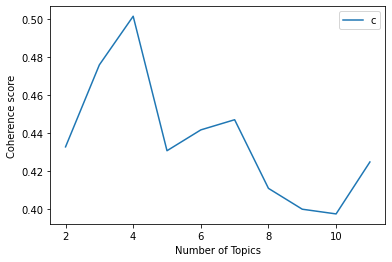

In [ ]:
plot_graph(dictionary, tfidf, correct_text, start, stop, step, model_list, coherence_values)

In [ ]:
index = coherence_values.index(max(coherence_values))
result = model_list[index].show_topics()
all_topics=[] #добавим в массив полученные топики
for i in range(len(result)):
  all_topics.append(result[i][1])
  print(result[i][1])

-0.177*"товар" + -0.165*"телефон" + -0.163*"магазин" + -0.141*"договор" + -0.128*"банк" + -0.124*"продавец" + -0.116*"деньга" + -0.111*"возврат" + -0.102*"вернуть" + -0.098*"услуга"
0.517*"банк" + 0.318*"кредит" + 0.209*"договор" + -0.200*"магазин" + -0.188*"товар" + 0.173*"страхование" + 0.159*"кредитный" + -0.132*"телефон" + -0.121*"продавец" + 0.112*"карта"
0.229*"дом" + -0.210*"телефон" + -0.173*"товар" + 0.172*"вода" + 0.170*"квартира" + -0.141*"кредит" + -0.134*"вернуть" + 0.127*"жилой" + -0.126*"возврат" + -0.124*"деньга"
0.399*"телефон" + 0.307*"ремонт" + -0.256*"магазин" + -0.252*"товар" + 0.166*"центр" + 0.162*"сервисный" + 0.124*"смартфон" + -0.121*"продавец" + -0.120*"цена" + -0.115*"ценник"


# *Часть 4 - классификация*

## *Подготовка*

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim
import pyLDAvis
import gensim

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#сократим количество слов в каждом топике до трех 
topics = []
for i in range(len(result)):
  topics.append(re.findall(r"[А-Яа-я]+", result[i][1]))
topics = [sublist[:3] for sublist in topics]
print(topics)

[['товар', 'телефон', 'магазин'], ['банк', 'кредит', 'договор'], ['дом', 'телефон', 'товар'], ['телефон', 'ремонт', 'магазин']]


In [ ]:
#сделаем лейблы
label_topics=['_'.join(i) for i in topics]

In [ ]:
#теперь создадим словарь и датафрэйм с топиком и его меткой
dict_topics = {'Topic': all_topics,'Label': label_topics}
t_l = pd.DataFrame(dict_topics, columns=['Topic','Label'])
t_l

,Topic,Label
0,"-0.177*""товар"" + -0.165*""телефон"" + -0.163*""ма...",товар_телефон_магазин
1,"0.517*""банк"" + 0.318*""кредит"" + 0.209*""договор...",банк_кредит_договор
2,"0.229*""дом"" + -0.210*""телефон"" + -0.173*""товар...",дом_телефон_товар
3,"0.399*""телефон"" + 0.307*""ремонт"" + -0.256*""маг...",телефон_ремонт_магазин


In [ ]:
#добавим индексацию, чтобы потом применить для соединения
t_l['Index'] = t_l.index

In [ ]:
#создадим матрицу топик-документ
matrix= gensim.matutils.corpus2dense(model_list[index][tfidf], len(model_list[index].projection.s)).T / model_list[index].projection.s
#добавляем столбец с номером максимально вероятного топика
matrix= pd.DataFrame(abs(matrix))
matrix_new= matrix.join(pd.DataFrame(matrix.idxmax(axis=1), columns = ['Index']))

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [ ]:
#теперь нам нужна таблица с текстом документа и номером максимально вероятного топика
summary_table = pd.DataFrame(my_text, columns = ['Text'])
summary_table = summary_table.join(matrix_new)
summary_table["Numbering"] = np.arange(len(summary_table))

In [ ]:
#соединяем таблицу с текстом и таблицу с метками через индекс(нумерацию, которую задавали в начале)
summary_table = summary_table.merge(t_l, on='Index').set_index("Numbering").loc[np.arange(len(summary_table)), :]

In [ ]:
#По итогу оставлям таблицу с текстом жалобы, нашей меткой и номером топика
final_table = summary_table[['Text', 'Label', 'Index']]
final_table

,Text,Label,Index
Numbering,,,
0,"02.02.2016 я сдала пару обуви, ранее приобрете...",телефон_ремонт_магазин,3
1,"02.02.16 я вернула пару обуви, ранее приобрете...",товар_телефон_магазин,0
2,Добрый день. 20.12.2015 я приобрел ботинки в о...,товар_телефон_магазин,0
3,"Интернет компания не выходит на связь, консуль...",товар_телефон_магазин,0
4,"Интернет компания не выходит на связь, консуль...",товар_телефон_магазин,0
...,...,...,...
996,"Добрый день.\r\nПо адресу Мос. обл., Ленинский...",дом_телефон_товар,2
997,"Помогите, пожалуйста. Очень холодно в квартире...",дом_телефон_товар,2
998,"Уже полгода не могу добиться счетов на оплату,...",товар_телефон_магазин,0


Для задачи классификации будем использовать градиентный бустинг, т.к. в прошлой работе данная модель показала наилучшее качество

## *Tfidf*

In [ ]:
#подготовим текст для классификации
text_for_model = []
for i in range(0, len(correct_text)):
  text_for_model.append(' '.join(correct_text[i]))

In [ ]:
#выделяем целевую переменную (y) и предикторы (x), разбиваем данные на тестовую и обучающую выборки
y = final_table['Label']
X = text_for_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# boosting
modelGB = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100)),
                     ])
modelGB.fit(X_train, y_train)
modelGB.score(X_train, y_train), modelGB.score(X_test, y_test)

(1.0, 0.6766467065868264)

## *Doc2vec*

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
#немного изменим таблицу, чтобы отдавать модели чистый текст 
summary_table2 = pd.DataFrame(text_for_model, columns = ['Text'])
summary_table2 = summary_table2.join(matrix_new)
summary_table2["Numbering"] = np.arange(len(summary_table2))

In [ ]:
summary_table2 = summary_table2.merge(t_l, on='Index').set_index("Numbering").loc[np.arange(len(summary_table2)), :]

In [ ]:
final_table2 = summary_table2[['Text', 'Label', 'Index']]
final_table2

,Text,Label,Index
Numbering,,,
0,сдать пара обувь ранее приобрести интернет маг...,телефон_ремонт_магазин,3
1,вернуть пара обувь ранее приобрести интернетма...,товар_телефон_магазин,0
2,добрый приобрести ботинок магазин сеть рандеву...,товар_телефон_магазин,0
3,интернет компания выходить связь консультацион...,товар_телефон_магазин,0
4,интернет компания выходить связь консультацион...,товар_телефон_магазин,0
...,...,...,...
996,добрый адрес мос обл ленинский рн видный мкр ю...,дом_телефон_товар,2
997,помочь очень холодно квартира батарея тёплый в...,дом_телефон_товар,2
998,полгода мочь добиться счёт оплата приходиться ...,товар_телефон_магазин,0


In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(final_table2.Text, final_table2.Label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
modelGB2 = GradientBoostingClassifier(n_estimators=100)
modelGB2.fit(train_vectors_dbow, y_train)
modelGB2.score(train_vectors_dbow, y_train), modelGB2.score(test_vectors_dbow, y_test)

(1.0, 0.6179401993355482)

# *Вывод*

В данной работе сравнивались два способа векторизациии текста tf-idf и doc2vec. 


Оценив качество двух моделей классификации через метрику точности accuracy, мы приходим к выводу, что первая модель, где векторизация текста была выполнена с помощью tf-idf, сработала лучше (имеет более высокую точность), по сравнению с моделью, где текст векторизировался с помощью doc2vec. То есть, мы можем сказать, что для данной задачи, способ преобразования текстовых данных в числовую форму, основанный на частотно-обратной частоте документа (tf-idf), подходит больше, чем doc2vec, где векторизация основывается не только на уровне текста, а на уровне документов. 

Это может быть связано с тем, что корпус, который мы используем в данной задаче, содержит в себе короткие документы, возможно, по этой причине tfidf сработал лучше doc2vec. 


По итогу проета получены следующие **результаты**:

* Тематическое моделирование с помощью **LSI**  показывает наиболее осмысленные результаты, чем  LDA

* Для векторизациии лучше использовать  **tf-idf**

* Модель классификации, построенная с помощью **градиентного бустинга** показывает большую точность, по сравнению с моделями, построенными на основе бэггинга и random forest.
